In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
import torchvision      
import os


In [2]:
from concepts_func import Classifier, InterpretableClassifier, args, load_data

Files already downloaded and verified


KeyboardInterrupt: 

In [3]:
model_save_path = 'models/interpretable_classifier_weights.pth'

In [4]:
train_loader, test_loader, train_dataset, test_dataset  = load_data(args)

100%|██████████| 170498071/170498071 [00:46<00:00, 3688285.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
classifier = InterpretableClassifier()
classifier.load_state_dict(torch.load(model_save_path))

# Switch model to evaluation mode
classifier.eval()

# Get a batch of test images
test_images, _ = next(iter(test_loader))

/tmp/ipykernel_21996/892967407.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(model_save_path))


In [144]:
"""
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Input channels = 3 (RGB), Output channels = 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Output channels = 64
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output channels = 128
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output channels = 256

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected (dense) layer
        self.fc = nn.Linear(128 * 2 * 2, 10)  # CIFAR-10 has 10 classes, 256 channels with 2x2 spatial size after pooling
        
    def forward(self, x):
        # Apply convolutions and max-pooling
        x = self.pool(F.relu(self.conv1(x)))  # (B, 32, 32, 32) -> (B, 32, 16, 16)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 16, 16) -> (B, 64, 8, 8)
        x = self.pool(F.relu(self.conv3(x)))  # (B, 64, 8, 8) -> (B, 128, 4, 4)
        x = self.pool(F.relu(self.conv4(x)))  # (B, 128, 4, 4) -> (B, 256, 2, 2)

        # Flatten the output before the classification layer
        x_flat = x.view(x.size(0), -1)  # Flatten the tensor to (B, 256 * 2 * 2)
        
        # Classification output
        class_output = self.fc(x_flat)  # (B, 10) - 10 classes
        
        # Return the output before the classification layer (conv4 output) and the classification output
        return x, class_output
"""

'\nclass Classifier(nn.Module):\n    def __init__(self):\n        super(Classifier, self).__init__()\n        \n        # Convolutional layers\n        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Input channels = 3 (RGB), Output channels = 32\n        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Output channels = 64\n        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output channels = 128\n        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output channels = 256\n\n        # Max pooling layer\n        self.pool = nn.MaxPool2d(2, 2)\n        \n        # Fully connected (dense) layer\n        self.fc = nn.Linear(128 * 2 * 2, 10)  # CIFAR-10 has 10 classes, 256 channels with 2x2 spatial size after pooling\n        \n    def forward(self, x):\n        # Apply convolutions and max-pooling\n        x = self.pool(F.relu(self.conv1(x)))  # (B, 32, 32, 32) -> (B, 32, 16, 16)\n        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 

In [6]:
def calculate_full_gradients(model, image):
    # Ensure the image requires gradients
    image.requires_grad = True

    # Forward pass to get the last-but-one layer output
    last_but_one_output, _ = model(image)

    # Prepare tensors to hold the gradients
    grad_image_wrt_last_but_one = torch.zeros(
        (last_but_one_output.size(1), last_but_one_output.size(2), last_but_one_output.size(3), 
         image.size(0), image.size(1), image.size(2), image.size(3))
    )  # Shape: (128, 2, 2, 1, 3, 32, 32)

    grad_last_but_one_wrt_image = torch.zeros(
        (image.size(0), image.size(1), image.size(2), image.size(3), 
         last_but_one_output.size(1), last_but_one_output.size(2), last_but_one_output.size(3))
    )  # Shape: (1, 3, 32, 32, 128, 2, 2)

    # Loop over each spatial position and channel of last_but_one_output
    for c in range(last_but_one_output.size(1)):
        for h in range(last_but_one_output.size(2)):
            for w in range(last_but_one_output.size(3)):
                # Zero gradients
                model.zero_grad()
                if image.grad is not None:
                    image.grad.zero_()

                # Get the scalar output for each position in the last-but-one layer output
                scalar_output = last_but_one_output[0, c, h, w]

                # Compute gradient of this scalar with respect to the input image
                scalar_output.backward(retain_graph=True)

                # Store the gradients
                grad_image_wrt_last_but_one[c, h, w] = image.grad.clone()  # Shape: (1, 3, 32, 32)

                # Accumulate the gradient of last-but-one layer with respect to the input image
                grad_last_but_one_wrt_image[:, :, :, :, c, h, w] = image.grad.clone()

    return grad_image_wrt_last_but_one, grad_last_but_one_wrt_image

In [7]:
def all_required_gradients(input_idx):
    # Get the input image
    input_image = test_images[input_idx].unsqueeze(0)

    # Calculate the gradients
    grad_image_wrt_last_but_one, grad_last_but_one_wrt_image = calculate_full_gradients(classifier, input_image)
    grad_image_sum_wrt_last_but_one = grad_image_wrt_last_but_one.sum(dim=(1, 2)).squeeze(0)

    return grad_image_wrt_last_but_one, grad_last_but_one_wrt_image, grad_image_sum_wrt_last_but_one

## Visualizing Features

In [176]:
import random
random_index = random.randint(0, test_images.size(0) - 1)
grad_image_wrt_last_but_one, grad_last_but_one_wrt_image, grad_image_sum_wrt_last_but_one = all_required_gradients(random_index)

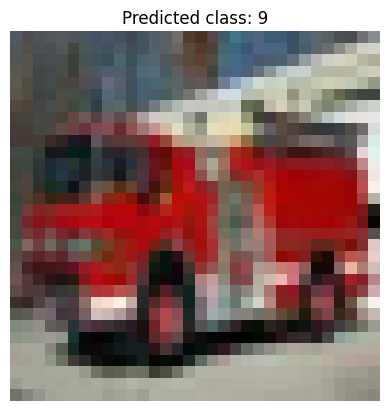

In [178]:
# Plot the image and print its predicted class
plt.imshow(test_images[random_index].permute(1, 2, 0))
plt.title(f'Predicted class: {classifier(test_images[random_index].unsqueeze(0))[1].argmax()}')
plt.axis('off')
plt.show()

In [179]:
!pip install cvxpy

Defaulting to user installation because normal site-packages is not writeable


In [216]:
cifar_10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
from scipy.optimize import linprog
import math
import cvxpy as cp

def compute_minimal_perturbation(weight_feature_new_class, weight_feature_all_classes, all_label_logits, new_label_logits, new_label):

    all_label_logits_np = all_label_logits.detach().numpy()
    new_label_logits_np = new_label_logits.detach().numpy()
    weight_feature_new_class_np = weight_feature_new_class.detach().numpy()
    weight_feature_all_classes_np = weight_feature_all_classes.detach().numpy()

    # Calculate all_other_label_logit_diff and all_other_weight_diff
    all_other_label_logit_diff = np.array([all_label_logits_np[i] - new_label_logits_np for i in range(10) if i != new_label])
    all_other_weight_diff = np.array([weight_feature_new_class_np - weight_feature_all_classes_np[i] for i in range(10) if i != new_label])
    all_other_weight_diff = all_other_weight_diff.reshape(all_other_weight_diff.shape[0], -1)
    # print(all_other_weight_diff.shape, all_other_label_logit_diff.shape)
    num_vars = all_other_weight_diff.shape[1]
    delta = cp.Variable(num_vars)

    # Define the objective function
    objective = cp.Minimize(cp.norm(delta, 2))

    # Define the constraints
    constraints = [all_other_weight_diff @ delta >= all_other_label_logit_diff + 30]

    # Create the problem and solve it
    problem = cp.Problem(objective, constraints)

    try:
        problem.solve()
        return delta.value, True
    except:
        return None, False
    

In [217]:
cifar_10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [218]:
image, label = test_dataset[random_index]
image = image.unsqueeze(0)

In [219]:
classifier_dense_layer = classifier.fc
classifier_dense_layer_weights = classifier_dense_layer.weight.data

In [220]:
encoding = classifier(image)[0].squeeze(0).detach()
all_label_logits = classifier(image)[1].squeeze(0).detach()
class_predictions = F.softmax(all_label_logits, dim=0)

In [230]:
# new_class is any class from 0 to 9 but not the original class
new_class = random.randint(0, 9) 
while new_class == label:
    new_class = random.randint(0, 9)
new_class = 0
print(f"Label to be changed from {label}: {cifar_10_class_names[label]} to {new_class}: {cifar_10_class_names[new_class]}")

Label to be changed from 9: truck to 0: airplane


In [231]:
new_label_logits = all_label_logits[new_class]
minimal_perturbations = []
ten_random_feature_indices = random.sample(range(0, encoding.size(0)), 10)
classifier_dense_layer_weights_reshaped = classifier_dense_layer_weights.reshape(classifier_dense_layer_weights.size(0), 128, 2, 2)
perturbed_encodings = []
for feature_index in range(encoding.size(0)):
    perturbed_encoding = encoding.clone()
    weight_feature_new_class = classifier_dense_layer_weights_reshaped[new_class, feature_index]
    weight_feature_all_classes = classifier_dense_layer_weights_reshaped[:, feature_index]

    minimal_perturbation, success = compute_minimal_perturbation(weight_feature_new_class, weight_feature_all_classes, all_label_logits, new_label_logits, new_class)
    if minimal_perturbation is not None:
        minimal_perturbation = minimal_perturbation.reshape(2, 2)
        perturbed_encoding[feature_index] += minimal_perturbation
        perturbed_encodings.append(perturbed_encoding)
        minimal_perturbations.append(minimal_perturbation)
    else:
        print("No minimal perturbation found for feature index", feature_index)
        perturbed_encodings.append(None)
        minimal_perturbations.append(None)
        
    

No minimal perturbation found for feature index 5
No minimal perturbation found for feature index 16
No minimal perturbation found for feature index 21
No minimal perturbation found for feature index 22
No minimal perturbation found for feature index 34
No minimal perturbation found for feature index 35
No minimal perturbation found for feature index 41
No minimal perturbation found for feature index 42
No minimal perturbation found for feature index 68
No minimal perturbation found for feature index 77


In [232]:
grad_image_wrt_last_but_one.shape, encoding.shape

(torch.Size([128, 2, 2, 1, 3, 32, 32]), torch.Size([128, 2, 2]))

In [241]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

perturbed_images = []
top_five_least_norm_del_images = []

initial_lr = 0.01  # Learning rate

# Set scaling factors
mse_weight = 1.0
cosine_similarity_weight = 1.0
mse_reconstruction_weight = 0.01

for index, perturbed_encoding in enumerate(perturbed_encodings):
    if perturbed_encoding is None:
        perturbed_images.append(None)
        continue

    perturbed_image = image.clone()
    perturbed_image.requires_grad_(True)

    optimizer = optim.Adam([perturbed_image], lr=initial_lr)
    max_iterations = 1000
    iteration = 0

    initial_loss = F.mse_loss(classifier(perturbed_image)[0].squeeze(0), perturbed_encoding)

    while max_iterations > 0:
        optimizer.zero_grad()

        obtained_encoding = classifier(perturbed_image)[0].squeeze(0)
        required_encoding = perturbed_encoding

        class_logits_from_perturbed_encoding = classifier_dense_layer(required_encoding.view(1, -1))
        class_logits_from_perturbed_image = classifier_dense_layer(obtained_encoding.view(1, -1))

        cosine_similarity_loss = F.cosine_embedding_loss(
            class_logits_from_perturbed_image,
            class_logits_from_perturbed_encoding,
            torch.tensor([1.0])
        )
        mse_loss = F.mse_loss(obtained_encoding, required_encoding)
        mse_reconstruction_loss = F.mse_loss(perturbed_image, image)

        # Apply scaling factors
        target_loss = (
            mse_weight * mse_loss +
            cosine_similarity_weight * cosine_similarity_loss +
            mse_reconstruction_weight * mse_reconstruction_loss
        )

        if target_loss.item() <= 10:
            print(f"Converged after {iteration} iterations with loss {target_loss.item()}, starting from {initial_loss.item()}")
            break

        target_loss.backward()
        optimizer.step()
        perturbed_image.requires_grad_(True)

        iteration += 1
        max_iterations -= 1

    del_image = perturbed_image - image
    perturbed_images.append(perturbed_image)

    if len(top_five_least_norm_del_images) < 5:
        top_five_least_norm_del_images.append((index, target_loss.item()))
    else:
        top_five_least_norm_del_images = sorted(top_five_least_norm_del_images, key=lambda x: x[1])
        if target_loss.item() < top_five_least_norm_del_images[-1][1]:
            top_five_least_norm_del_images[-1] = (index, target_loss.item())

    print(f"Index {index}, MSE Loss: {mse_loss.item()}, Norm of Perturbation: {torch.norm(del_image)}, "
          f"Cosine similarity loss: {cosine_similarity_loss.item()}, MSE Reconstruction Loss: {mse_reconstruction_loss.item()}, "
          f"Total Loss: {target_loss.item()}")

top_five_least_norm_del_images = sorted(top_five_least_norm_del_images, key=lambda x: x[1])


Index 0, MSE Loss: 94.01905059814453, Norm of Perturbation: 97.14540100097656, Cosine similarity loss: 0.08373445272445679, MSE Reconstruction Loss: 3.0681350231170654, Total Loss: 94.13346099853516
Index 1, MSE Loss: 122026.515625, Norm of Perturbation: 290.65948486328125, Cosine similarity loss: 0.2592623829841614, MSE Reconstruction Loss: 27.4522705078125, Total Loss: 122027.046875
Index 2, MSE Loss: 6041.5625, Norm of Perturbation: 4.087653636932373, Cosine similarity loss: 0.3458890914916992, MSE Reconstruction Loss: 0.00544111430644989, Total Loss: 6041.908203125
Index 3, MSE Loss: 2369.4384765625, Norm of Perturbation: 219.45327758789062, Cosine similarity loss: 0.39134877920150757, MSE Reconstruction Loss: 15.656547546386719, Total Loss: 2369.986328125
Index 4, MSE Loss: 148.9427947998047, Norm of Perturbation: 85.10667419433594, Cosine similarity loss: 0.6152200698852539, MSE Reconstruction Loss: 2.3555755615234375, Total Loss: 149.58157348632812
Index 6, MSE Loss: 153.2067413

In [242]:
top_five_least_norm_del_images

[(9, 9.983748435974121),
 (79, 9.992274284362793),
 (36, 15.701104164123535),
 (101, 16.727588653564453),
 (104, 20.78780746459961)]

In [243]:
len(perturbed_images)

128

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


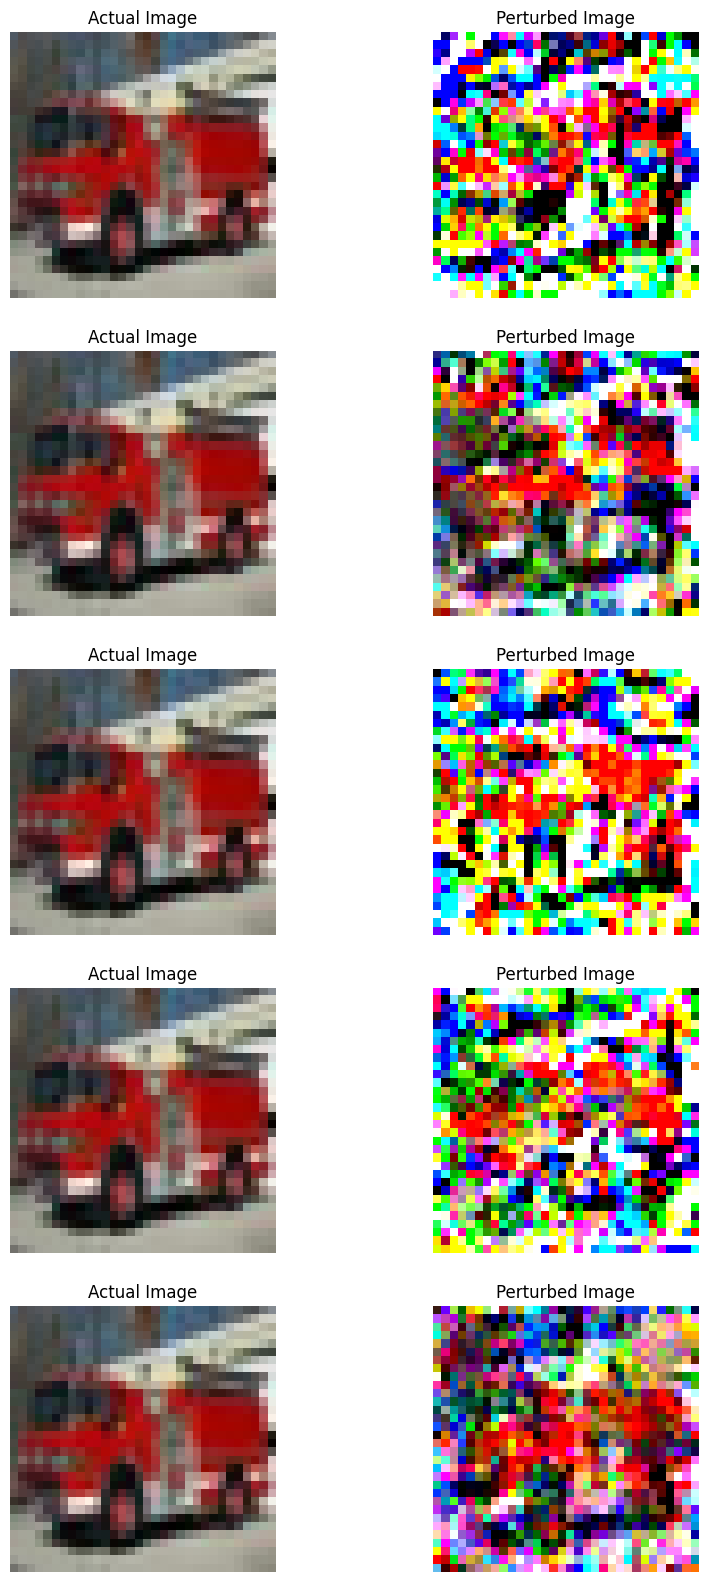

In [244]:
# Visualize the actual and perturbed images side by side for the top 5 least norm delta images
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i, (index, norm_del_image) in enumerate(top_five_least_norm_del_images):
    actual_image = image.squeeze(0).permute(1, 2, 0).detach().numpy()
    perturbed_image = perturbed_images[index].squeeze(0).permute(1, 2, 0).detach().numpy()
    axs[i, 0].imshow(actual_image)
    axs[i, 0].set_title(f"Actual Image")
    axs[i, 0].axis('off')
    axs[i, 1].imshow(perturbed_image)
    axs[i, 1].set_title(f"Perturbed Image")
    axs[i, 1].axis('off')

In [245]:
for i, (idx, norm_del_image) in enumerate(top_five_least_norm_del_images):
    original_class_logits = all_label_logits
    class_logits_from_perturbed_encoding = classifier_dense_layer(perturbed_encodings[idx].view(1, -1))
    original_class_logit_in_perturbed_encoding = class_logits_from_perturbed_encoding[0, label]
    required_class_logit_in_perturbed_encoding = class_logits_from_perturbed_encoding[0, new_class]
    predicted_class_logit_from_perturbed_encoding = class_logits_from_perturbed_encoding.max()
    predicted_class_name_from_perturbed_encoding = cifar_10_class_names[class_logits_from_perturbed_encoding.argmax()]

    perturbed_image = perturbed_images[idx]
    encoding_of_perturbed_image = classifier(perturbed_image)[0].squeeze(0)
    class_logits_from_perturbed_image = classifier_dense_layer(encoding_of_perturbed_image.view(1, -1))
    predicted_class_logit_from_perturbed_image = class_logits_from_perturbed_image.max()
    predicted_class_name_from_perturbed_image = cifar_10_class_names[class_logits_from_perturbed_image.argmax()]
    required_encoding = perturbed_encodings[idx]
    print(f"Norm of difference in encodings = {F.mse_loss(encoding_of_perturbed_image, required_encoding)}")
    print(f"Norm of image difference = {torch.norm(perturbed_image - image)}")
    print(f"Original Class : {label} : {cifar_10_class_names[label]}")
    print(f"New Class : {new_class} : {cifar_10_class_names[new_class]}")
    print("=============================================")
    print(f'Original class logits: {original_class_logits}')
    print(f'Class logits from perturbed encoding: {class_logits_from_perturbed_encoding}')
    print(f'Original class logit in perturbed encoding: {original_class_logit_in_perturbed_encoding}')
    print(f'Required class logit in perturbed encoding: {required_class_logit_in_perturbed_encoding}')
    print(f'Predicted class logit from perturbed encoding: {predicted_class_logit_from_perturbed_encoding}')
    print(f'Predicted class name from perturbed encoding: {predicted_class_name_from_perturbed_encoding}')
    print("=============================================")
    print(f'Class logits from perturbed image: {class_logits_from_perturbed_image}')
    print(f'Predicted class logit from perturbed image: {predicted_class_logit_from_perturbed_image}')
    print(f'Predicted class name from perturbed image: {predicted_class_name_from_perturbed_image}')
    print("=============================================")
    print("=============================================")

Norm of difference in encodings = 9.94623851776123
Norm of image difference = 77.51457214355469
Original Class : 9 : truck
New Class : 0 : airplane
Original class logits: tensor([ -9.3963,  11.0548,  -6.8805,  -7.0492, -22.4755, -13.7384,  -5.3635,
        -18.7197, -18.5860,  25.2402])
Class logits from perturbed encoding: tensor([[ 74.2373,  24.2373,  24.2373, -61.7149,  16.7828, -73.8537, -66.1094,
         -40.1202, -44.1512,  24.2373]], grad_fn=<AddmmBackward0>)
Original class logit in perturbed encoding: 24.237285614013672
Required class logit in perturbed encoding: 74.23729705810547
Predicted class logit from perturbed encoding: 74.23729705810547
Predicted class name from perturbed encoding: airplane
Class logits from perturbed image: tensor([[ 65.0653,  27.6997,   4.5925, -62.7602,  13.2370, -72.5702, -74.9840,
         -24.8142, -36.4986,  18.0547]], grad_fn=<AddmmBackward0>)
Predicted class logit from perturbed image: 65.06526947021484
Predicted class name from perturbed imag

In [246]:
# Print all the results
